# Perspektiva obrazu - kartézský a polární souřadný systém
Cvičení je zaměřené na práci s polárními souřadnicemi při využití nestandardních 360° objektivů od firmy [Opto Engineering](https://www.opto-e.com/). Způsob použití takových objektivů je demonstrován v [tutoriálu](https://www.opto-e.com/resources/peripheric-optics-tutorial) na stránkách výrobce. Jedná o následující optické systémy:

## Optické systémy
Pericentrický objektiv | <img src="images/peri.jpg" width="45%"> | Boroskopická sonda | <img src="images/boro.jpg" width="45%">
-|-|-|-

[Pericentrický objektiv](https://www.opto-e.com/products/pericentric-lenses#Media) umožňuje podívat se nejen na vršek objektu, ale dokonce i na jeho strany zároveň. Typickými aplikacemi jsou například kontrola potisků víček či kontrola defektů [hrdel lahví](https://www.visiononline.org/vision-resources-details.cfm/vision-resources/Wine-Bottle-Vision-Inspection-System/content_id/6450).

[Boroskopická sonda](https://www.opto-e.com/products/boroscopic-probes#Overview) díky zrcadlu umožnuje podívat se 360 ° dokola kolem sebe. Typickými aplikacemi jsou průmyslové inspekce děr či kontroly správnosti závitů. 

## Souřadné systémy
Potřebnou prerekvizitou je znalost existence **kartézského** a **polárního** souřadného systému a tedy dvojí možnosti zápisu souřadnic. Pěkně je to vysvětleno například na webu [Math is fun](https://www.mathsisfun.com/polar-cartesian-coordinates.html).

Proč budeme tuto znalost potřebovat je jasné ve chvíli, když si zobrazíte ukázky obrázků získaných jednotlivými optickými systémy.

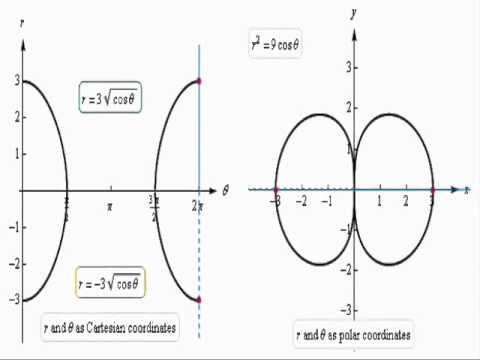

In [1]:
# Youtube video s ukázkami funkcí v kartézských a polárních souřadnicích
from IPython.display import Audio, Image, YouTubeVideo
YouTubeVideo(id='Uros5bufLJI', width=600, height=300)

---

### Import knihoven a konfigurace

In [ ]:
import os
import io

import cv2
import numpy as np
import matplotlib.pyplot as plt

from improutils import *

%matplotlib inline
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

### Pomocné funkce
Z následujících funkcí je potřeba vybírat ty vhodné pro splnění úkolu.

Seznam funkcí pro přehlednost:
- [`connect_camera(...)`](../svz.ipynb#connect_functions)
- [`show_images(...)`](../svz.ipynb#show_functions)
- [`plot_images(...)`](../svz.ipynb#show_functions)


- [`to_gray(...)`](../svz.ipynb#preprocessing_functions)
- [`to_hsv(...)`](../svz.ipynb#preprocessing_functions)
- [`negative(...)`](../svz.ipynb#preprocessing_functions)
- [`crop(...)`](../svz.ipynb#preprocessing_functions)


- [`segmentation_one_threshold(...)`](../svz.ipynb#segmentation_functions)
- [`segmentation_auto_threshold(...)`](../svz.ipynb#segmentation_functions)
- [`segmentation_two_thresholds(...)`](../svz.ipynb#segmentation_functions)
- [`segmentation_adaptive_threshold(...)`](../svz.ipynb#segmentation_functions)
- [`find_contours(...)`](../svz.ipynb#segmentation_functions)


- [`filtration_median(...)`](../svz.ipynb#filtration_functions)
- [`fill_holes(...)`](../svz.ipynb#filtration_functions)


- [`ocr(...)`](../svz.ipynb#ocr)


- [`to_intensity(...)`](../svz.ipynb#others)
- [`logical_and(...)`](../svz.ipynb#others)


- [`warp_to_cartesian(...)`](../svz.ipynb#cart_polar_functions)
- [`warp_to_polar(...)`](../svz.ipynb#cart_polar_functions)
- [`rotate(...)`](../svz.ipynb#cart_polar_functions)


- [`artificial_circle_image(...)`](../svz.ipynb#artificial_funtions)

---

### Úkol
Seznamte se s transformací mezi kartézským a polárním systémem souřadnic. Vyzkoušejte si, jak transformace funguje jak na umělých datech, tak na datech reálných. Uvědomte si, jak záleží na správném nastavení měřicího systému při vizuální kontrole pomocí 360° objektivů.

Pro testování jsou připraveny funkce `warp_to_cartesian()` a `warp_to_polar()`. 

#### 1) Vytvořte umělý obrázek soustředných kružnic
Zvolte vlastní velikost obrázku (doporučuje se velikost mezi 200 a 1000). Následně na obrázek aplikujte transformaci a oba obrázky zobrazte.

In [ ]:
art_circ_image = ...(512) ### tvorba umělého obrázku
art_circ_image_trans = ...(art_circ_image) ### správná transformace

plot_images(art_circ_image, art_circ_image_trans, normalize=True)

#### 2) Vytvořte funkci pro generování umělého obrázku
Umělý obrázek by se měl stávat ze samých svislých čar (viz výsledek [Úkolu 1](#1\)-Vytvořte-umělý-obrázek-soustředných-kružnic)). Následně na obrázek aplikujte transformaci a zobrazte oba obrázky.

In [ ]:
def artificial_line_image(size):
    ### vlastní postup
    
    
    return img_art_line

In [ ]:
art_line_image = artificial_line_image(512)
art_line_image_trans = ...(art_line_image) ### správná transformace

plot_images(art_line_image, art_line_image_trans, normalize=True)

#### 3) Zobrazte testovací obrázek
Načtěte testovací obrázek z boroskopické sondy `mech_test.png`. Zobrazte ho společně s jeho transformací.

In [ ]:
image_path = '...' ### cesta k obrázku
image_test = cv2.imread(image_path)

image_test_trans = ...(image_test) ### správná transformace

# Zobrazí obrázky
plot_images(image_test, image_test_trans)

#### 4) Přečtěte text na testovacím obrázku
Vytvořte jednoduchý algoritmus předzpracování obrazu pro čtení pomocí OCR.

In [ ]:
def preprocess_for_ocr(img):
    ### vlastní postup
    
    
    return img

In [ ]:
# Předzpracuje obrázek a zobrazí
image_ocr = preprocess_for_ocr(image_test_trans)
plot_images(image_ocr)

# Přečte pomocí OCR
text = ocr(image_ocr)
print(text.split('\n')[0])

#### 5) Načtěte uložený obrázek a přečtěte text bar kódu
Načtěte obrázek krabičky pořízené pomocí pericentrického objektivu.

<img src="images/sample_container.jpg" width="50%">

In [ ]:
image_saved_path = '...' ### cesta k obrázku
image = ...(image_saved_path) ### načtení obrázku

image_warped = ...(image) ### správná transformace
plot_images(image, image_warped)

Ořízněte si obrázek podle souřadnic bar kódu (lze zjistit ručně). Dále zpracujte obrázek tak, abyste získali ideální binární obraz, který lze využít pro OCR čtení nástrojem Tesseract.

Klasické workflow zpracování obrazu je následující: *oříznutí*, *filtrace*, *segmentace*, *výběr vhodných objektů*.

![](images/workflow.png)

In [ ]:
# Doplňte souřadnice pro oříznutí obrázku
# Formát: TL_x, TL_y, BR_x, BR_y
# ... TL = top-left, BR = bottom-right
CROP_COORDINATES = [
    ###
    
]

# Předzpracování
image_proc = to_gray(image_warped)

# Oříznutí
image_proc = crop(image_proc, *CROP_COORDINATES)

### vlastní postup












# Zobrazení výsledků
plot_images(image_proc, ..., ..., ...) ###

Přečtěte pomocí OCR nástrojem Tesseract.

In [ ]:
ref = '8017 6312'

# Čtení pomocí OCR
text = ocr(...) ### doplnit

# Zhodnocení
if ref in text:
    print('Výborně')
else:
    print('Skoro. Vyšlo ti: ' + text)